In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as tsaplots
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional


In [32]:
# from google.colab import drive
# drive.mount('/content/drive')

In [33]:
df=pd.read_csv('../Dataset/GVR Historical Data.csv')

In [34]:
# Checking null value
df.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [35]:
df.dtypes

Date        object
Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object

In [36]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
  df['Price'] = df['Price'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Vol.'] = df['Vol.'].apply(convert_to_number)
  df['Change %'] = df['Change %'].apply(lambda x: float(x.strip('%'))/100)

In [37]:
tranformData(df)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-06-02,18900.0,18950.0,19000.0,18600.0,2720000.0,0.0053
1,2023-06-01,18800.0,18350.0,18900.0,18100.0,4250000.0,0.0330
2,2023-05-31,18200.0,18450.0,18450.0,18000.0,3140000.0,-0.0109
3,2023-05-30,18400.0,18300.0,18500.0,17850.0,4580000.0,0.0110
4,2023-05-29,18200.0,17200.0,18200.0,17050.0,6080000.0,0.0581
...,...,...,...,...,...,...,...
1287,2018-03-28,11327.0,10736.0,11622.0,10637.0,139800.0,0.0550
1288,2018-03-27,10736.0,10637.0,10834.0,10342.0,52200.0,0.0583
1289,2018-03-26,10145.0,10046.0,10342.0,10046.0,267800.0,-0.0190
1290,2018-03-23,10342.0,10440.0,10440.0,9849.0,111800.0,-0.0367


In [38]:
df=df.set_index('Date')
df = df.sort_index()
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-03-22,10736.0,10834.0,11130.0,10046.0,260800.0,0.0000
2018-03-23,10342.0,10440.0,10440.0,9849.0,111800.0,-0.0367
2018-03-26,10145.0,10046.0,10342.0,10046.0,267800.0,-0.0190
2018-03-27,10736.0,10637.0,10834.0,10342.0,52200.0,0.0583
2018-03-28,11327.0,10736.0,11622.0,10637.0,139800.0,0.0550
...,...,...,...,...,...,...
2023-05-29,18200.0,17200.0,18200.0,17050.0,6080000.0,0.0581
2023-05-30,18400.0,18300.0,18500.0,17850.0,4580000.0,0.0110
2023-05-31,18200.0,18450.0,18450.0,18000.0,3140000.0,-0.0109


In [39]:
fig = px.line(df, x=df.index, y=df.Price,labels={'Date':'Date','Price':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='Stock close price for chart of HSG', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [40]:
def prepare_data_for_gan(df, num_steps):
    data = df.values
    data = data.reshape(-1, 1)  # Chuyển đổi dữ liệu thành ma trận 2D (số mẫu, 1)

    # Chuẩn hóa dữ liệu về khoảng [0, 1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    # Chia dữ liệu thành các chuỗi con có độ dài num_steps
    X = []
    for i in range(len(data) - num_steps):
        X.append(data[i:i+num_steps])

    # Chuyển đổi thành numpy array
    X = np.array(X)

    # Tính số lượng mẫu trong tập huấn luyện, tập kiểm tra
    train_size = int(len(df) * 0.6)
    test_size = int(0.2 * len(df))
    val_size = len(df) - train_size - test_size


    train_data = data[:train_size]
    test_data = data[train_size:train_size+test_size]
    val_data = data[train_size+test_size:]

    return train_data, test_data, val_data, scaler


In [41]:
# Số lượng bước thời gian trong mỗi chuỗi con
num_steps = 10

# Chuẩn bị dữ liệu cho mô hình Time-GAN
train_data, test_data, val_data, scaler = prepare_data_for_gan(df['Price'], num_steps)

# In số lượng mẫu trong mỗi tập dữ liệu
print("Số lượng mẫu trong tập huấn luyện:", train_data.shape)
print("Số lượng mẫu trong tập kiểm tra:", test_data.shape)
print("Số lượng mẫu trong tập valid: ", val_data.shape)

Số lượng mẫu trong tập huấn luyện: (775, 1)
Số lượng mẫu trong tập kiểm tra: (258, 1)
Số lượng mẫu trong tập valid:  (259, 1)


In [42]:
def build_time_gan(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    return model

# Xác định input_shape
input_shape = (num_steps, 1)

# Xây dựng mô hình Time-GAN
model = build_time_gan(input_shape)

# In thông tin về mô hình
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 10, 128)          33792     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 10, 128)           0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 10, 128)          98816     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 10, 128)           0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                      

In [43]:
def train_time_gan(model, train_data, epochs, num_steps):
    X_train = []
    y_train = []
    for i in range(len(train_data) - num_steps):
        X_train.append(train_data[i:i+num_steps])
        y_train.append(train_data[i+num_steps])
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1)
    return history



# Số lượng time steps
epochs = 100

# Huấn luyện mô hình Time-GAN
history = train_time_gan(model, train_data, epochs, num_steps)


Epoch 1/100
24/24 [==============================] - 18s 41ms/step - loss: 0.0092
Epoch 2/100
24/24 [==============================] - 1s 43ms/step - loss: 0.0017
Epoch 3/100
24/24 [==============================] - 1s 46ms/step - loss: 0.0012
Epoch 4/100
24/24 [==============================] - 1s 56ms/step - loss: 0.0014
Epoch 5/100
24/24 [==============================] - 1s 43ms/step - loss: 0.0014
Epoch 6/100
24/24 [==============================] - 1s 41ms/step - loss: 0.0014
Epoch 7/100
24/24 [==============================] - 1s 46ms/step - loss: 0.0011
Epoch 8/100
24/24 [==============================] - 1s 51ms/step - loss: 0.0014
Epoch 9/100
24/24 [==============================] - 1s 48ms/step - loss: 9.2817e-04
Epoch 10/100
24/24 [==============================] - 1s 40ms/step - loss: 0.0012
Epoch 11/100
24/24 [==============================] - 1s 42ms/step - loss: 0.0011
Epoch 12/100
24/24 [==============================] - 1s 43ms/step - loss: 9.7986e-04
Epoch 13/100
24/

1/1 [==============================] - 0s 31ms/step
Validation RMSE: 0.6846695826328799
Testing RMSE: 0.24864190037507136


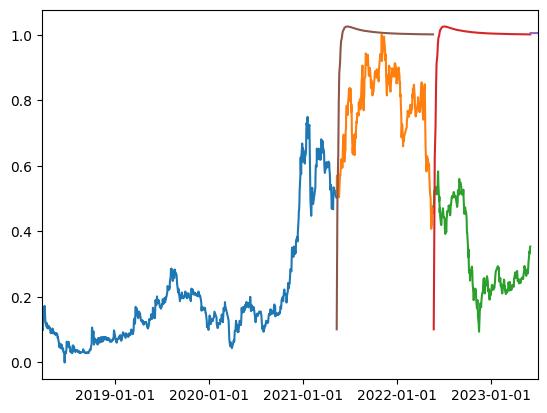

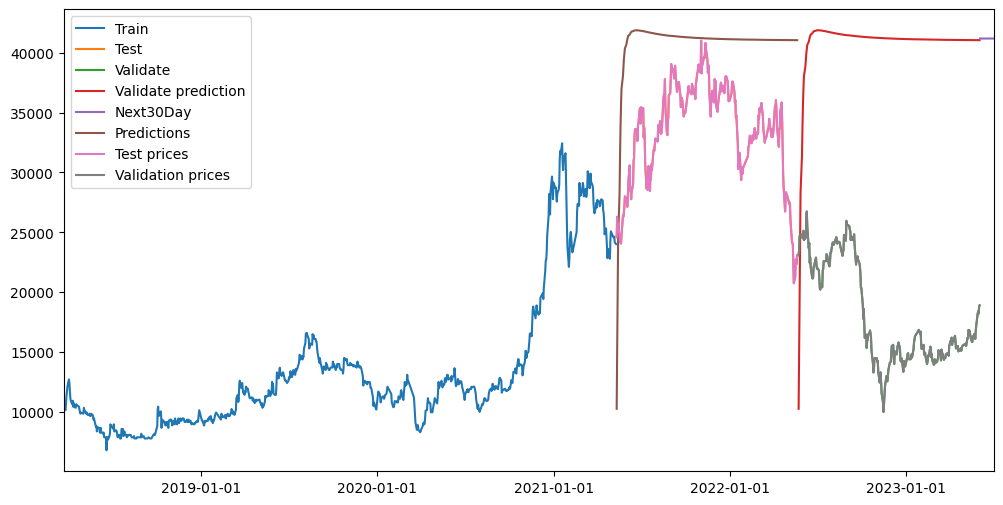

In [44]:
import matplotlib.dates as mdates

# Quá trình testing
x_test = np.arange(len(test_data)).reshape(-1, 1)
y_test = np.array(test_data)
y_pred = model.predict(x_test)

# Quá trình validate
x_val = np.arange(len(val_data)).reshape(-1, 1)
y_val = np.array(val_data)
y_pred_val = model.predict(x_val)

# Quá trình validate
x_val = np.arange(len(val_data)).reshape(-1, 1)
y_val = np.array(val_data)
y_pred_val = model.predict(x_val)

# Tạo dataframe dự báo cho 30 ngày tiếp theo
last_date = pd.to_datetime(df.index[-1])
forecast_dates = pd.date_range(last_date, periods=30, freq='D')[1:]
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Price': np.zeros(len(forecast_dates))})

# Dự đoán giá đóng cửa cho 30 ngày tiếp theo
x_next_30_days = np.arange(len(df), len(df) + len(forecast_df)).reshape(-1, 1)
y_next_30_days = model.predict(x_next_30_days)

# Đưa các dự đoán vào dataframe forecast_df
forecast_df['Price'] = y_next_30_days

# Tính toán RMSE cho quá trình validate và testing
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
# Convert dates to a more appropriate format
dates = pd.to_datetime(df.index)

# Vẽ biểu đồ
plt.plot(dates[:len(train_data)], train_data)
plt.plot(dates[len(train_data):len(train_data)+len(test_data)], test_data)
plt.plot(dates[len(train_data)+len(test_data):len(train_data)+len(test_data)+len(val_data)], val_data)
plt.plot(dates[len(train_data)+len(test_data):len(train_data)+len(test_data)+len(val_data)], y_pred_val)
plt.plot(forecast_df.Date, forecast_df.Price)
plt.plot(dates[len(train_data):len(train_data)+len(test_data)], y_pred)

# Set x-axis range
plt.xlim(dates[0], forecast_dates[-1])

# Set x-axis ticks
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

import matplotlib.dates as mdates

# Chuyển về các số liệu gốc
test_dates = dates[len(train_data):len(train_data)+len(test_data)]
val_dates = dates[len(train_data)+len(test_data):len(train_data)+len(test_data)+len(val_data)]
test_prices = scaler.inverse_transform(test_data.reshape(-1, 1)).flatten()
val_prices = scaler.inverse_transform(val_data.reshape(-1, 1)).flatten()
test_pred_prices = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
val_pred_prices = scaler.inverse_transform(y_pred_val.reshape(-1, 1)).flatten()
forecast_prices = scaler.inverse_transform(forecast_df['Price'].values.reshape(-1, 1)).flatten()

# Vẽ biểu đồ với số liệu gốc
plt.figure(figsize=(12, 6))
plt.plot(dates[:len(train_data)], scaler.inverse_transform(train_data), label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(val_dates, val_prices, label='Validate')
plt.plot(val_dates, val_pred_prices, label='Validate prediction')
plt.plot(forecast_dates, forecast_prices, label='Next30Day')
plt.plot(dates[len(train_data):len(train_data)+len(test_data)], test_pred_prices, label='Predictions')

# Set x-axis range
plt.xlim(dates[0], forecast_dates[-1])

# Set x-axis ticks
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Chuyển về các số liệu gốc
test_dates = dates[len(train_data):len(train_data)+len(test_data)]
val_dates = dates[len(train_data)+len(test_data):len(train_data)+len(test_data)+len(val_data)]
test_prices = df['Price'].values[len(train_data):len(train_data)+len(test_data)]
val_prices = df['Price'].values[len(train_data)+len(test_data):len(train_data)+len(test_data)+len(val_data)]

# Vẽ biểu đồ với số liệu gốc
plt.plot(test_dates, test_prices, label='Test prices')
plt.plot(val_dates, val_prices, label='Validation prices')

# Hiển thị chú thích và hiển thị biểu đồ
plt.legend()
plt.show()


In [45]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((val_pred_prices - val_prices )**2))
test_rmse = np.sqrt(np.mean((test_pred_prices - test_prices)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
from sklearn.metrics import mean_absolute_percentage_error


vail_mape = mean_absolute_percentage_error(val_prices, val_pred_prices)
test_mape = mean_absolute_percentage_error(test_prices, test_pred_prices)
print('Validation MAPE:', vail_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 23421.17552897838
Testing RMSE: 8505.540778735902
Validation MAPE: 1.3961159582534204
Testing MAPE: 0.24575294611216375
